In [1]:
import numpy as np
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
os.chdir('../..')

In [3]:
# events
events = pd.read_csv("data/LOBSTER/AMZN_2012-06-21_34200000_57600000_events_5.csv")

In [4]:
# preprocess
messages = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_5.csv',header=None)
orderbook = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_5.csv',header=None)

messages_columns = ["time","type","id","size","price","direction"]
messages.columns = messages_columns

orderbook_columns = []
for i in range(1,6):
    orderbook_columns.append("ask_price_" + str(i))
    orderbook_columns.append("ask_size_" + str(i))
    orderbook_columns.append("bid_price_" + str(i))
    orderbook_columns.append("bid_size_" + str(i))
orderbook.columns = orderbook_columns

# Feature engineering

- Avg. trades / min to be computed

In [5]:
# the orderbook snapshots correspond to snapshots AFTER events
orderbook["time"] = messages["time"]

# feature engineering
orderbook["midprice"] = (orderbook["ask_price_1"] + orderbook["bid_price_1"]) / 2
orderbook["spread"] = orderbook["ask_price_1"] - orderbook["bid_price_1"]
orderbook["midprice_returns"] = np.log(orderbook["midprice"]).diff()
orderbook["rolling_vol"] = (orderbook["midprice_returns"]**2).rolling(window=1000).mean()
orderbook["volume_imbalance"] = (orderbook["bid_size_1"] - orderbook["ask_size_1"]) / (orderbook["ask_size_1"] + orderbook["bid_size_1"])
orderbook["microprice"] = orderbook["midprice"]+(orderbook["volume_imbalance"]*orderbook["spread"])
# why mid_price in microprice?
seconds_per_day = 3600*24
orderbook['cos_time'] = np.cos(2*np.pi*orderbook['time']/seconds_per_day)
orderbook['sin_time'] = np.cos(2*np.pi*orderbook['time']/seconds_per_day)

In [6]:
messages['datetime'] = pd.to_datetime(messages['time'], unit='s')
orderbook['datetime'] = pd.to_datetime(orderbook['time'], unit='s')

messages.set_index('datetime', inplace=True)
orderbook.set_index('datetime', inplace=True)

orderbook["roll_avg_trades_per_min"] = messages["size"].rolling(window='5min').sum()/5

- The volatility is estimated using a rolling mean of 1000 trades over the squared returns of the midprice timeseries.  
- 5-minute bucket average statistics for the trading volume.

# Datapoints from events

In [7]:
# key parameter
horizon = 100 # in number of trade, not ms

datapoints = {}
for idx,row in tqdm(events.iloc[:10000].iterrows()):
    t_sub, lifetime, cause, level = list(row)
    level = int(level)
    subdf = orderbook[(orderbook["time"] <= t_sub)].iloc[-horizon:]
    X = subdf.drop(columns=["time","midprice_returns"]).to_numpy(dtype=np.float32)
    if ~ np.isnan(X).any():
        assert len(X) == horizon
        if level not in datapoints:
            datapoints[level] = []
        datapoints[level].append((X,lifetime,int(cause)))

0it [00:00, ?it/s]

In [8]:
# test
test = datapoints[list(datapoints.keys())[0]][0]
X, lifetime, cause = test
print(X.shape, lifetime, cause)

(100, 28) 0.0101436339973588 0


# Model

Some remarks:
- One convolutional network per head
- FC layer applied after

## A personal trial

After several readings, two things remain very unclear.
- Are there 3 DCC per head ? If not, a multihead attention with a 1D query and key is useless.
- Once the series have been processed, what's the fully connected linear layer mentionned ?
  
Using `flow-forecast` seems like the best solution (could even be better).

In [9]:
class MyLittleEncoder(nn.Module):

    def __init__(self, n_time_series, kernel_size):
        super().__init__()

        # transformers params
        n_heads = 4
        
        self.convolutions = []
        for i in range(n_time_series):
            self.convolutions.append(nn.Conv1d(1, 1, kernel_size, padding=kernel_size//2))
        raise NotImplementedError
    
    def forward(self, x):
        pass

Some implementations:
- https://github.com/mlpotter/Transformer_Time_Series
- https://github.com/ghsama/ConvTransformerTimeSeries
- https://github.com/AIStream-Peelout/flow-forecast

## From flow-forecast

In [10]:
from transformer_bottleneck import DecoderTransformer

In [11]:
class Encoder(nn.Module):

    def __init__(self, n_time_series):
        super().__init__()

        # transformers params
        forecast_history = 100 # horizon
        num_layer = 1
        n_head = 4
        self.n_time_series = n_time_series # number of features, may change
        n_embd = 0 # ???
        dropout = 0.1
        self.q_len = 1 # ???
        
        # conv transformer
        self.transformer = DecoderTransformer(n_time_series,
                                              n_head,
                                              num_layer,
                                              n_embd,
                                              forecast_history, 
                                              dropout,
                                              self.q_len,
                                              {},
                                              forecast_length=4,
                                              scale_att=False,
                                              sub_len=3)
    
    def forward(self, x):
        x = self.transformer(x)
        return x

In [12]:
# test
n_timeseries = X.shape[1]
mlm = Encoder(n_timeseries)
batch = torch.tensor(X[np.newaxis,:],dtype=torch.float)
phi = mlm(batch)
print("\noutput shape: ",phi.shape)
print(phi)

x before block:  torch.Size([1, 100, 28])
query:  torch.Size([1, 4, 100, 28])
key:  torch.Size([1, 4, 28, 100])
value:  torch.Size([1, 4, 100, 28])
after merge_heads:  torch.Size([1, 100, 112])
after c_proj:  torch.Size([1, 100, 28])
after attention:  torch.Size([1, 100, 28])
after ln1:  torch.Size([1, 100, 28])
after mlp1:  torch.Size([1, 100, 28])
h:  torch.Size([1, 100, 28])

output shape:  torch.Size([1, 4])
tensor([[ 0.0585,  0.0960,  0.0659, -0.0498]], grad_fn=<SqueezeBackward1>)


c:\Users\Paul\Documents\X\4A\S1\ML\limit_order_book\notebooks\paul\transformer_bottleneck.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  position = torch.tensor(torch.arange(length), dtype=torch.long).to(self.device)


**About the weights initialization**  
One wants:
$\mathbb{E}[w=e^{logw}]=1$  
which implies $\mu = -\sigma²/2 = -a²/6$
and $a = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}$

In [13]:
class Decoder(nn.Module):
    # Only supports batch

    def __init__(self):
        super().__init__()
        # Params
        input_dim,output_dim = 4,1
        architecture = [input_dim,16,16,output_dim]

        # fc first layer
        self.fc = nn.Linear(input_dim, architecture[1],bias=False)

        # log-weights
        self.log_weights = []
        self.log_weights.append(nn.Parameter(torch.Tensor(architecture[1], 1)))
        for i in range(1, len(architecture) - 1):
            self.log_weights.append(nn.Parameter(torch.Tensor(architecture[i + 1],architecture[i])))
        
        # reset parameters
        self.reset_parameters()

    def reset_parameters(self):
        for log_weight in self.log_weights:
            nn.init.xavier_uniform_(log_weight)
            log_weight.data -= 1/sum(list(log_weight.data.shape))


    def forward(self, phi, t, grad=False):
        # forward
        if t.ndim < 2:
            t = torch.unsqueeze(t,-1)
        t.requires_grad = True

        # first layer
        phi = self.fc(phi)
        phi += nn.functional.linear(t, self.log_weights[0].exp())
        phi = nn.functional.tanh(phi)
        # print("phi after the first layer: ",phi)

        # next layers
        for log_weight in self.log_weights[1:-1]:
            phi = nn.functional.linear(phi, log_weight.exp())
            phi = nn.functional.tanh(phi)
            # print("phi: ",phi)

        # last layer
        phi = nn.functional.linear(phi, self.log_weights[-1].exp())
        phi = nn.functional.sigmoid(phi)
        phi = torch.squeeze(phi, dim=-1)
        # print("phi: ",phi)

        # grad if necessary
        if grad:
            phi.backward(retain_graph=True)
            grad = torch.squeeze(t.grad,dim=-1)
            self.zero_grad()
            return phi, grad
        return phi

In [14]:
# test
lifetime,cause = torch.tensor([lifetime]),torch.tensor([cause])
decoder = Decoder()
decoder(phi,lifetime)

tensor([0.9970], grad_fn=<SqueezeBackward1>)

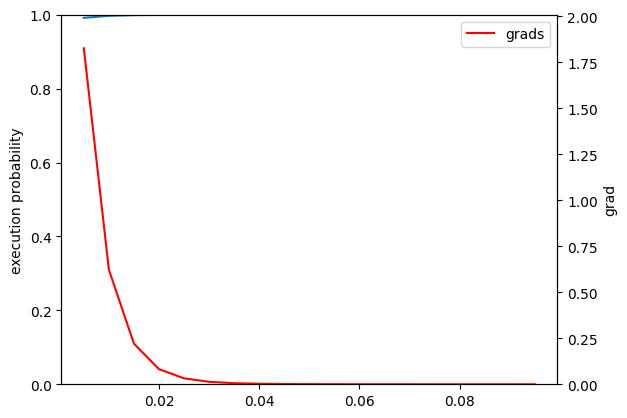

In [15]:
# another test
probas,grads = [],[]
scale = 1e-1
interval = np.arange(0.05*scale,1*scale,0.05*scale)
for t in interval:
    t = torch.tensor([t],dtype=torch.float)
    proba,grad = decoder(phi,t,True)
    probas.append(float(proba))
    grads.append(float(grad))

plt.plot(interval,probas,label="probas")
plt.ylabel("execution probability")
plt.ylim(0,1)
twin = plt.gca().twinx()
twin.plot(interval,grads,c='r',label="grads")
twin.set_ylabel("grad")
twin.set_ylim(0,1.1*max(grads))
plt.legend()

In [32]:
class EncoderDecoder(nn.Module):

    def __init__(self, n_time_series):
        super().__init__()
        self.encoder = Encoder(n_time_series)
        self.decoder = Decoder()
        
    
    def forward(self, x, t, grad=False):
        phi = self.encoder(x)
        if grad:
            exec_probas,hazard_rates = self.decoder(phi,t,True)
            return exec_probas,hazard_rates
        exec_probas = self.decoder(phi,t)
        return exec_probas
    
    def train(self,dataloader):
        # set up
        loss_list = []
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-6)

        # train, manual batch
        for batch,lifetime,status in dataloader:
            optimizer.zero_grad()
            mean_loss = 0
            for i in range(dataloader.batch_size):
                X,t,cause = batch[i:i+1].float(),lifetime[i:i+1].float(), status[i:i+1].float()
                exec_probas,hazard_rates = self.forward(X,t, True)
                loss = torch.mean(cause*torch.log(hazard_rates)+(1-cause)*torch.log(1-exec_probas))
                loss.backward()
                mean_loss += float(loss)/dataloader.batch_size
            if math.isnan(mean_loss):
                    break
            optimizer.step()
            loss_list.append(mean_loss)
            print("loss: ",float(loss))
            
        return loss_list

In [33]:
# test
my_little_model = EncoderDecoder(28)
proba = my_little_model(batch,lifetime)

proba,grad = my_little_model(batch,lifetime,True)
print(proba,grad)

tensor([0.9780], grad_fn=<SqueezeBackward1>) tensor([5.2440])


Text(0, 0.5, 'grad')

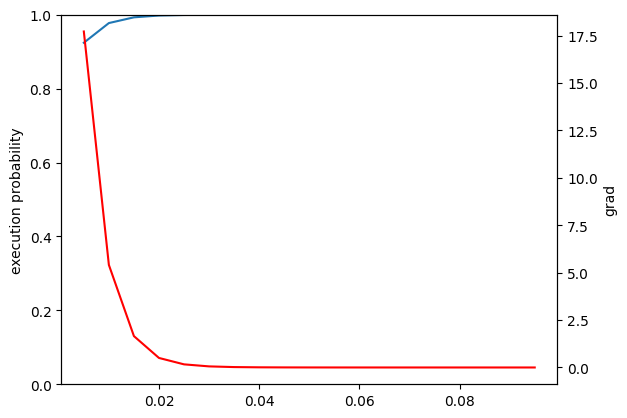

In [34]:
# another test
probas,grads = [],[]
scale = 1e-1
interval = np.arange(0.05*scale,1*scale,0.05*scale)
for t in interval:
    t = torch.tensor([t],dtype=torch.float)
    proba,grad = my_little_model(batch,t,True)
    probas.append(float(proba))
    grads.append(float(grad))

plt.plot(interval,probas)
plt.ylabel("execution probability")
plt.ylim(0,1)
twin = plt.gca().twinx()
twin.plot(interval,grads,c='r')
twin.set_ylabel("grad")

## Training

In [35]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, datapoints):
        self.datapoints = datapoints
        
    def __len__(self):
        return len(self.datapoints)
    
    def __getitem__(self, idx):
        return self.datapoints[idx]
    
# Create the dataset
dataset = MyDataset(datapoints[0]) # level 0

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Tests:
- test without right censored elements
- monitor the gradient flow

In [38]:
math.isnan(loss_list[0])

True

loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan
loss:  nan


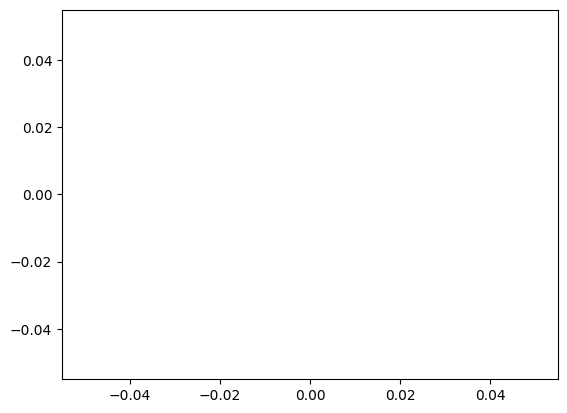

In [36]:
# train
loss_list = my_little_model.train(dataloader)
plt.plot(loss_list)